In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os
import io
import copy
import cv2
import glob
import nd2
import toml
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
from qd_analysis.fig import setup_plotting_env

In [3]:
config = toml.load("../preprocessing/config.toml")
fig_dir = config["dirs"]["figs"]
os.makedirs(fig_dir, exist_ok=True)

In [4]:
nd2_dir = os.path.join(config["dirs"]["data"], "bead_tests/")

In [5]:
nd2s = sorted(glob.glob(os.path.join(nd2_dir, "*.nd2")))

In [6]:
data = {}
for img in tqdm(nd2s):
    fileparts = os.path.splitext(os.path.basename(img))[0].split("-")
    brand = fileparts[0]
    img_type = fileparts[-1]
    if brand not in data.keys():
        data[brand] = {}
    data[brand][img_type] = {}
    with nd2.ND2File(img) as f:
        data[brand][img_type]["data"] = f.asarray().astype("uint16")
        data[brand][img_type]["voxel_size"] = f.voxel_size()

  0%|          | 0/22 [00:00<?, ?it/s]

In [7]:
brands = list(data.keys())

In [8]:
colors = [(0, 0, 0), (1, 0, 0)]  # cmap goes from black (0, 0, 0) to red (1, 0, 0)
fluo_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("Custom", colors, N=2**16)

In [9]:
bf_kwargs = {"vmin": 0, "vmax": 1., "cmap": "grey"}
fluo_kwargs = {"vmin": 0, "vmax": 6000, "cmap": fluo_cmap}

In [12]:
setup_plotting_env()

In [14]:
scale_bar = 500 # in microns

In [15]:
height, width = data["amid"]["cy7"]["data"].shape

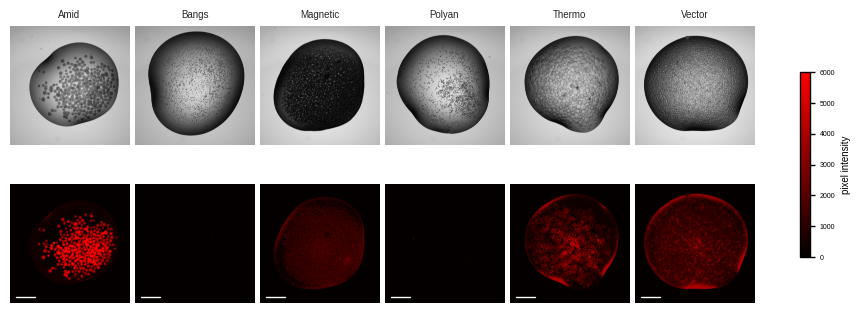

In [16]:
fig, ax = plt.subplots(
    2,
    len(brands),
    figsize=(2 * len(brands), 4),
    gridspec_kw={"wspace": 0.05, "hspace": 0.05},
)
for _ax, _brand in zip(ax[0], brands):
    norm_im = data[_brand]["bf"]["data"].copy()
    norm_im = (norm_im - norm_im.min()) / (norm_im.max() - norm_im.min())
    _ax.imshow(norm_im, **bf_kwargs)
    _ax.set_title(_brand.title())
    _ax.axis("off")

for _ax, _brand in zip(ax[1], brands):
    h = _ax.imshow(data[_brand]["cy7"]["data"], **fluo_kwargs)
    _ax.axis("off")
    _ax.plot([100, 100 + scale_bar / data[_brand]["bf"]["voxel_size"].x], [height - 100, height - 100], "w-")

cbar = fig.colorbar(h, ax=list(ax.ravel()), shrink=0.6)
cbar.set_label("pixel intensity")
fig.savefig(os.path.join(fig_dir, "bead_comparison.pdf"), bbox_inches="tight", dpi=600)